In [39]:
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
from optuna.trial import TrialState
import joblib

import statistics
from sklearn.model_selection import KFold
import time
from utils import calculate_metric

from pytorch_tabular.models import GANDALFConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
    ExperimentConfig
)
from pytorch_tabular import TabularModel
import matplotlib.pyplot as plt

In [2]:
# sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
# set random seeds
np.random.seed(0)
torch.manual_seed(0)

In [3]:
INPUT_FILE = "../data/data_removing_na.xlsx"
MODEL_PATH = '../output/transformer'
BATCH_SIZE = 32
PROJECT_NAME = "run/GANDALF"

DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
NO_DEVICE = 4

In [4]:
DEVICE

device(type='cpu')

In [5]:
df = pd.read_excel(INPUT_FILE)

In [6]:
df.head()

,rr1_30,currency,seniorioty_adj,coupon rate,domicile_country,exchange_country,Industry_sector,Industry_group,Industry_subgroup,event_type,...,PD_55_pd,PD_56_pd,PD_57_pd,PD_58_pd,PD_59_pd,PD_60_pd,DTD,NI_Over_TA,Size,defaulted_in_last_6_months
0,0.259908,USD,Senior Subordinated Unsecured,9.000,United States,United States,Consumer Discretionary,Retail & Whsle - Discretionary,E-Commerce Discretionary,Bankruptcy Filing,...,0.396731,0.397453,0.398148,0.398819,0.399467,0.400092,-0.732815,-0.007137,-0.852484,False
1,0.032729,USD,Senior Subordinated Unsecured,5.750,United States,United States,Health Care,Health Care,Health Care Facilities & Svcs,Default Corp Action,...,0.957454,0.957467,0.957480,0.957492,0.957503,0.957514,-1.666262,-0.000286,-1.186347,False
2,0.972400,USD,Unsecured,5.675,South Korea,South Korea,Consumer Discretionary,Retail & Whsle - Discretionary,Wholesale - Discretionary,Default Corp Action,...,0.568169,0.568693,0.569197,0.569682,0.570150,0.570600,-1.853366,0.000191,1.053677,False
3,1.047416,CHF,Unsecured,0.125,South Korea,South Korea,Consumer Discretionary,Retail & Whsle - Discretionary,Wholesale - Discretionary,Default Corp Action,...,0.568169,0.568693,0.569197,0.569682,0.570150,0.570600,-1.853366,0.000191,1.053677,False
4,0.848872,JPY,Unsecured,1.750,Japan,Japan,Industrials,Industrial Products,Electrical Equipment,Bankruptcy Filing,...,0.130285,0.130688,0.131081,0.131465,0.131840,0.132206,-0.768857,-0.028058,-1.946507,False


In [7]:
df.shape

(1725, 165)

In [8]:
feature_list = df.columns
feature_list = feature_list.drop('rr1_30')

In [9]:
feature_list

Index(['currency', 'seniorioty_adj', 'coupon rate', 'domicile_country',
       'exchange_country', 'Industry_sector', 'Industry_group',
       'Industry_subgroup', 'event_type', 'event_type_subcategory_sum',
       ...
       'PD_55_pd', 'PD_56_pd', 'PD_57_pd', 'PD_58_pd', 'PD_59_pd', 'PD_60_pd',
       'DTD', 'NI_Over_TA', 'Size', 'defaulted_in_last_6_months'],
      dtype='object', length=164)

In [10]:
category_features = list(df.select_dtypes(include=['object', 'bool']).columns)
non_category_features = [i for i in feature_list if i not in category_features]

In [11]:
print(len(non_category_features))
print(len(category_features))

153
11


In [12]:
category_features

['currency',
 'seniorioty_adj',
 'domicile_country',
 'exchange_country',
 'Industry_sector',
 'Industry_group',
 'Industry_subgroup',
 'event_type',
 'event_type_subcategory_sum',
 'defaulted_in_last_5_years',
 'defaulted_in_last_6_months']

In [13]:
# split data into training and test set
test_size = 0.25
train, test = train_test_split(df, test_size=test_size, random_state=42)

In [14]:
train.head()

,rr1_30,currency,seniorioty_adj,coupon rate,domicile_country,exchange_country,Industry_sector,Industry_group,Industry_subgroup,event_type,...,PD_55_pd,PD_56_pd,PD_57_pd,PD_58_pd,PD_59_pd,PD_60_pd,DTD,NI_Over_TA,Size,defaulted_in_last_6_months
755,0.082481,USD,Senior Unsecured,7.500,United States,United States,Energy,Oil & Gas,Oil & Gas Producers,Default Corp Action,...,0.691011,0.691382,0.691738,0.692080,0.692408,0.692725,-1.084433,-0.052027,-2.074964,False
588,0.378845,USD,Unsecured,6.000,Indonesia,Indonesia,Materials,Materials,Metals & Mining,Default Corp Action,...,0.183801,0.184996,0.186167,0.187313,0.188437,0.189539,-0.540409,0.017209,0.864692,False
585,0.836149,USD,Senior Secured,11.000,United States,United States,Materials,Materials,Metals & Mining,Default Corp Action,...,0.278774,0.280216,0.281615,0.282972,0.284290,0.285571,0.754647,-0.010395,-0.342209,False
1329,0.987208,USD,Senior Secured,9.125,United States,United States,Energy,Oil & Gas,Oil & Gas Services & Equip,Default Corp Action,...,0.190375,0.191471,0.192544,0.193594,0.194622,0.195628,-0.242080,-0.022618,-2.808528,False
973,1.021458,USD,Senior Secured,9.250,United States,United States,Energy,Oil & Gas,Oil & Gas Producers,Default Corp Action,...,0.149501,0.150930,0.152327,0.153692,0.155027,0.156332,1.138686,0.000033,-0.085154,False


TUNING PARAMETERS

In [15]:
EPOCHS = 100
target_col = 'rr1_30'

data_config = DataConfig(
    target=[
        target_col
    ],  # target should always be a list
    continuous_cols=non_category_features,
    categorical_cols=category_features,
)
trainer_config = TrainerConfig(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS,
    early_stopping=None,
    devices=NO_DEVICE
)
optimizer_config = OptimizerConfig()
experiment_config = ExperimentConfig(project_name=PROJECT_NAME,exp_watch="all",log_target="tensorboard")

In [17]:
# empty cache first
torch.cuda.empty_cache()

In [18]:
def objective(trial):
    #Number of layers in the feature abstraction
    gflu_stages = trial.suggest_int("gflu_stages", 1, 10, log=True)
    
    #initial percentage of features to be selected in each GFLU stage.
    gflu_feature_init_sparsity = trial.suggest_float("gflu_feature_init_sparsity", 0.1, 1, log=True)
    gflu_dropout = trial.suggest_float("gflu_dropout", 0, 0.5)

    # Generate the optimizers.
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    
    model_config = GANDALFConfig(
            task="regression",
            gflu_stages=gflu_stages,    #Number of layers in the feature abstraction
            gflu_feature_init_sparsity=gflu_feature_init_sparsity, #initial percentage of features to be selected in each GFLU stage.
            gflu_dropout=gflu_dropout,
            learning_rate=lr,
        )
    # Initialize the model
    tabular_model = TabularModel(
            data_config=data_config,
            model_config=model_config,
            optimizer_config=optimizer_config,
            trainer_config=trainer_config,
            experiment_config=experiment_config,
            verbose=True
        )

    # training with 5-fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    datamodule = None
    model = None

    for index, (train_idx, val_idx) in enumerate(kf.split(train)):
        # Create training and validation datasets for the current fold
        train_fold, val_fold = train.iloc[train_idx], train.iloc[val_idx]
        
        if datamodule is None:
            # Initialize datamodule and model in the first fold
            # uses train data from this fold to fit all transformers
            datamodule = tabular_model.prepare_dataloader(
                train=train_fold, validation=val_fold, seed=42
            )
            model = tabular_model.prepare_model(datamodule)
        else:
            # Creates a copy of the datamodule with same transformers but different train and validation data
            datamodule = datamodule.copy(train=train_fold, validation=val_fold)
            
        # Train the model
        tabular_model.train(model, datamodule)

        # Validation of the model.
        val_res = tabular_model.evaluate(val_fold)

        trial.report(val_res[0]['test_loss'], index)

    # Return the average validation loss across all folds
    return val_res[0]['test_loss']

In [19]:
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2025-03-25 09:36:08,118] A new study created in memory with name: no-name-276ed5e9-0912-452a-9a08-a467af38d7d6


2025-03-25 09:36:08,245 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-03-25 09:36:08,259 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because

2025-03-25 09:36:08,320 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-03-25 09:36:10,320 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-03-25 09:36:16,565 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-03-25 09:36:16,595 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nguyenhoa/hoa/up5/final/src/saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  340 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 343 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 343 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 28                                                                                          
Modules in eval mode: 0

Output()

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connec
tor.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connec
tor.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The 
number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-03-25 09:39:53,235 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-03-25 09:39:53,241 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because

Output()

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.05464093014597893    │
│  test_mean_squared_error  │    0.05464093014597893    │
└───────────────────────────┴───────────────────────────┘

2025-03-25 09:39:53,502 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because

2025-03-25 09:39:53,546 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-03-25 09:39:53,563 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nguyenhoa/hoa/up5/final/src/saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  340 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 343 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 343 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 28                                                                                          
Modules in eval mode: 0

Output()

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connec
tor.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connec
tor.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The 
number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-03-25 09:44:57,734 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-03-25 09:44:57,735 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because

Output()

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.04786225035786629    │
│  test_mean_squared_error  │    0.04786225035786629    │
└───────────────────────────┴───────────────────────────┘

2025-03-25 09:44:58,406 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because

2025-03-25 09:44:59,159 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-03-25 09:44:59,189 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nguyenhoa/hoa/up5/final/src/saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  340 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 343 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 343 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 28                                                                                          
Modules in eval mode: 0

Output()

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connec
tor.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connec
tor.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The 
number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-03-25 09:49:35,407 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-03-25 09:49:35,409 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because

Output()

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03247836232185364    │
│  test_mean_squared_error  │    0.03247836232185364    │
└───────────────────────────┴───────────────────────────┘

2025-03-25 09:49:35,653 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because

2025-03-25 09:49:35,689 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-03-25 09:49:35,705 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nguyenhoa/hoa/up5/final/src/saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  340 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 343 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 343 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 28                                                                                          
Modules in eval mode: 0

Output()

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connec
tor.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connec
tor.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The 
number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-03-25 09:52:49,993 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-03-25 09:52:50,008 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because

Output()

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.033739086240530014    │
│  test_mean_squared_error  │   0.033739086240530014    │
└───────────────────────────┴───────────────────────────┘

2025-03-25 09:52:51,871 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because

2025-03-25 09:52:51,920 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-03-25 09:52:51,970 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nguyenhoa/hoa/up5/final/src/saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  340 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 343 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 343 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 28                                                                                          
Modules in eval mode: 0

Output()

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connec
tor.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connec
tor.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The 
number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-03-25 09:57:38,666 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-03-25 09:57:38,713 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because

Output()

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.0357816144824028     │
│  test_mean_squared_error  │    0.0357816144824028     │
└───────────────────────────┴───────────────────────────┘

[I 2025-03-25 09:57:39,809] Trial 0 finished with value: 0.0357816144824028 and parameters: {'gflu_stages': 1, 'gflu_feature_init_sparsity': 0.7517028756773947, 'gflu_dropout': 0.310129872375981, 'learning_rate': 0.011357265478429133}. Best is trial 0 with value: 0.0357816144824028.


Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.0357816144824028
  Params: 
    gflu_stages: 1
    gflu_feature_init_sparsity: 0.7517028756773947
    gflu_dropout: 0.310129872375981
    learning_rate: 0.011357265478429133


In [20]:
trial.params

{'gflu_stages': 1,
 'gflu_feature_init_sparsity': 0.7517028756773947,
 'gflu_dropout': 0.310129872375981,
 'learning_rate': 0.011357265478429133}

In [ ]:
best_param = trial.params

In [16]:
best_param = {'gflu_stages': 1,
 'gflu_feature_init_sparsity': 0.7517028756773947,
 'gflu_dropout': 0.310129872375981,
 'learning_rate': 0.011357265478429133}

RUNNING THE MODEL

In [21]:
# empty cache first
torch.cuda.empty_cache()

In [25]:
EPOCHS = 100

trainer_config = TrainerConfig(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS,
    early_stopping=None,
    # devices=NO_DEVICE
)


model_config = GANDALFConfig(
    **best_param,
    task="regression",
    metrics=["mean_absolute_error", "mean_absolute_percentage_error", "mean_squared_error", "r2_score"]
)


In [26]:
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    experiment_config=experiment_config,
    verbose=True
)

In [27]:
tabular_model.fit(train=train) #validation=test) #by default, it takes 20% of the data as validation to select the best epoch

Seed set to 42


2025-03-27 11:31:07,250 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-03-27 11:31:07,263 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-03-27 11:31:07,313 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-03-27 11:31:07,384 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-03-27 11:31:07,404 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-03-27 11:31:07,463 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  340 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 343 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 343 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 28                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-03-27 11:36:42,133 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-03-27 11:36:42,137 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

In [28]:
pred_df = tabular_model.predict(test)
pred_df.head()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

,rr1_30_prediction
339,0.314092
598,0.689059
300,0.801744
1510,0.505176
433,0.673632


In [29]:
 # save metrics
mae, mape, rmse, rsqr = calculate_metric(pred_df.to_numpy().squeeze(), test[target_col].to_numpy())
print(f"Test average mean absolute error: {mae}")
print(f"Test average mean absolute percentage error: {mape}")
print(f"Test average root mean squared error: {rmse}")
print(f"Test average R2: {rsqr}")

Test average mean absolute error: 0.20276503444970756
Test average mean absolute percentage error: 403.2296696962782
Test average root mean squared error: 0.26496129074271163
Test average R2: 0.38709587615764707


In [30]:
tabular_model.feature_importance().sort_values("importance", ascending=False)

,Features,importance
79,Long-term_ratio,1.567964e-02
118,PD_18_pd,9.753947e-03
14,Ratio to MA,9.725981e-03
153,PD_53_pd,9.332140e-03
22,US Generic Govt 12 Month Yield,9.199717e-03
...,...,...
155,PD_55_pd,1.783115e-10
144,PD_44_pd,1.758396e-10
140,PD_40_pd,1.746743e-10
115,PD_15_pd,1.666518e-10


In [46]:
# Explain a single instance using the GradientShap method and baseline as 10000 samples from the training data
kernelSHAP = tabular_model.explain(test, method="KernelShap", baselines="b|1000")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/tabular_model.py:2020: UserWarning: KernelShap is computationally expensive and will take some time. For faster results, try usingsome other methods like GradientShap, IntegratedGradients etc.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Libr

In [47]:
feature_importance = kernelSHAP.abs().median().sort_values(ascending=False)


In [48]:
feature_importance

Industry_subgroup             0.026590
domicile_country              0.012166
coupon rate                   0.010371
Industry_group                0.009736
event_type_subcategory_sum    0.008374
                                ...   
PD_38_pd                      0.001684
liquidity_ratio               0.001670
PD_12_domicile_sector         0.001634
sector_dtd                    0.001625
Size                          0.001545
Length: 164, dtype: float32

In [49]:
feature_importance_df = feature_importance.reset_index()
feature_importance_df.columns = ["Feature", "Importance"]

<Figure size 1400x600 with 0 Axes>

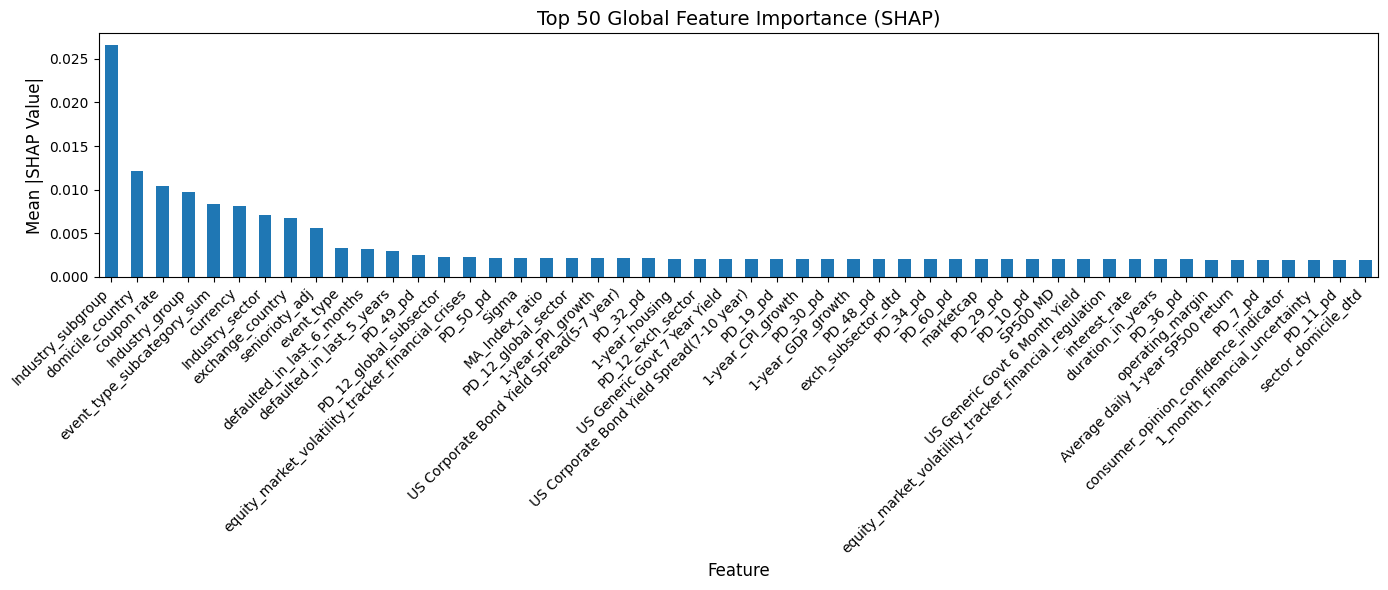

In [50]:
# Select the top 50 features
top_features = feature_importance_df.head(50)

# Set a larger figure size
plt.figure(figsize=(14, 6))

# Create the bar plot for top 50 features
top_features.plot(
    kind="bar", x="Feature", y="Importance", legend=False, figsize=(14, 6)
)

# Add title and labels
plt.title("Top 50 Global Feature Importance (SHAP)", fontsize=14)
plt.ylabel("Mean |SHAP Value|", fontsize=12)
plt.xlabel("Feature", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()

In [32]:
# saving model
joblib.dump(tabular_model, f"{PROJECT_NAME}/final_models/final.joblib")

['run/GANDALF/final_models/final.joblib']

5 fold CV

In [33]:
# Define cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
EPOCHS = 500
val_mae = []
val_mape = []
val_rmse = []
val_rsqr = []

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    experiment_config=experiment_config,
    verbose=True
)

trainer_config = TrainerConfig(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS,
    early_stopping=None
)

model = None
datamodule = None

for index, (train_idx, val_idx) in enumerate(kf.split(df)):
        # Create training and validation datasets for the current fold
        train_fold, val_fold = df.iloc[train_idx], df.iloc[val_idx]
        
        if datamodule is None:
            # Initialize datamodule and model in the first fold
            # uses train data from this fold to fit all transformers
            datamodule = tabular_model.prepare_dataloader(
                train=train_fold, validation=val_fold, seed=42
            )
            model = tabular_model.prepare_model(datamodule)
        else:
            # Creates a copy of the datamodule with same transformers but different train and validation data
            datamodule = datamodule.copy(train=train_fold, validation=val_fold)
            
        # Train the model
        tabular_model.train(model, datamodule)
        pred_df = tabular_model.predict(val_fold)

        # Validation of the model.
        mae, mape, rmse, rsqr = calculate_metric(pred_df.to_numpy().squeeze(), val_fold[target_col].to_numpy())
        val_mae.append(mae)
        val_mape.append(mape)
        val_rmse.append(rmse)
        val_rsqr.append(rsqr)

2025-03-27 11:36:43,236 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-03-27 11:36:43,250 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-03-27 11:36:43,332 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-03-27 11:36:43,444 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-03-27 11:36:43,474 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-03-27 11:36:43,544 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  355 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.8 K │ train │
│ 2 │ _head            │ Sequential       │    245 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 358 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 358 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 28                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
val_rmse

[0.29893204490461195,
 0.28676149441184196,
 0.260360608362095,
 0.252864688137029,
 0.24041399344901898]

In [ ]:
print(f"Test average mean absolute error: {statistics.mean(val_mae)}")
print(f"Test average mean absolute percentage error: {statistics.mean(val_mape)}")
print(f"Test average root mean squared error: {statistics.mean(val_rmse)}")
print(f"Test average R2: {statistics.mean(val_rsqr)}")

Test average mean absolute error: 0.21320731905445486
Test average mean absolute percentage error: 3376.7316955052315
Test average root mean squared error: 0.2678665658529194
Test average R2: 0.34381419201652874
